# A/B Тест

**Цель проекта: Необходтимо совместно с отделом маркетинга подготовить список гипотез для увеличения выручки.**

### Импортируем библиотеки

In [1]:
import pandas as pd
import datetime as dt
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
from datetime import datetime, timedelta
import warnings

### Загрузим данные и подготовим их к анализу

In [2]:
visitors, orders, hypothesis = (
        pd.read_csv('D:/DA/projects/visitors.csv'),  
        pd.read_csv('D:/DA/projects/orders.csv'),  
        pd.read_csv('D:/DA/projects/hypothesis.csv')
    )

#### Изучим visitors

In [3]:
display(
    visitors.head(10),
    visitors.info()    
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


None

Описание данных visitor:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

#### Изучим orders

In [4]:
display(
    orders.head(10),
    orders.info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


None

Описание данных orders:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

#### Изучим hypothesis

In [5]:
pd.set_option("max_colwidth", 999)
display(
    hypothesis.head(10),
    hypothesis.info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


None

Описание данных orders:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [6]:
hypothesis.columns = [x.lower() for x in hypothesis.columns.values]

#### Проверим на наличие пропусков

In [7]:
display(
    visitors.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm'),
    orders.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm'),
    hypothesis.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')
)

,0
date,0.00%
group,0.00%
visitors,0.00%


,0
transactionId,0.00%
visitorId,0.00%
date,0.00%
revenue,0.00%
group,0.00%


,0
hypothesis,0.00%
reach,0.00%
impact,0.00%
confidence,0.00%
efforts,0.00%


#### Проверим на наличие дубликатов

In [8]:
display(
    visitors.duplicated().sum(), 
    orders.duplicated().sum(),
    hypothesis.duplicated().sum()
)

0

0

0

#### Преобразуем данные связанные с датой

In [9]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

#### Выводы

- Изучили данные;
- Пропуски отсутствуют;
- Дубликаты отсутствуют;
- Преобразовали данные "data"

In [10]:
# Выясним сколько у нас групп в тесте
visitors['group'].unique()

array(['A', 'B'], dtype=object)

In [11]:
# выясним временной интервал теста
print(f'Дата начала теста: {visitors["date"].min()}')

Дата начала теста: 2019-08-01 00:00:00


In [12]:
print(f'Дата окончания теста: {visitors["date"].max()}')

Дата окончания теста: 2019-08-31 00:00:00


Тест проводился в августе 2019г.

In [13]:
#Количество заказов в каждой группе
orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

In [14]:
# пользователи в обеих группах
doubles = orders.groupby(['visitorId']).agg({'group' : 'nunique'}).reset_index()
print(f'Пользователей, попавших в обе группы: {doubles[doubles.group != 1]["visitorId"].count()}')

Пользователей, попавших в обе группы: 58


### Приоритизация гипотез

#### Применим фреймворк ICE для приоритизации гипотез. Отсортируим их по убыванию приоритета.

In [15]:
hypothesis['ICE'] =round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 2)
hypothesis_new = hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

hypothesis_new

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


По ICE наиболее перспективные гипотезы:
- 8	Запустить акцию, дающую скидку на товар в день рождения
- 0	Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- 7	Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	

#### Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [16]:
hypothesis['RICE'] = round(hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 2)
hypothesis_new = hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending = False)
hypothesis_new

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


По RICE наиболее перспективные гипотезы:
- 7	Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- 2	Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- 0	Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

#### Как изменилась приоритизация гипотез при применении RICE вместо ICE:

При применении метода RICE гипотеза под номером 8 "Запустить акцию, дающую скидку на товар в день рождения" перемистилась с первой позиции на пятую. А гипотеза под номером 7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" переместилась с третий позиции на первую.


### Анализ A/B-теста

#### Построим график кумулятивной выручки по группам

In [42]:
# создаем массив уникальных значений
dates_groups = orders[['date', 'group']].drop_duplicates()

In [43]:
# получаем агрегированные кумулятивные по дням данные о заказах
orders_aggregated = dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg(
        {'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}
    ), axis=1).sort_values(by=['date', 'group'])

# получаем агрированные кумулятивные по дням данные о поситителях интерент-магазина
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg(
        {'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}
    ), axis=1).sort_values(by=['date', 'group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам названия
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulative_data.head()


,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Даты начала и окончания теста совпадают с исходными данными

In [44]:
print(f'Начало теста: {cumulative_data["date"].min()}')

Начало теста: 2019-08-01 00:00:00


In [45]:
print(f'Окончание теста: {cumulative_data["date"].max()}')

Окончание теста: 2019-08-31 00:00:00


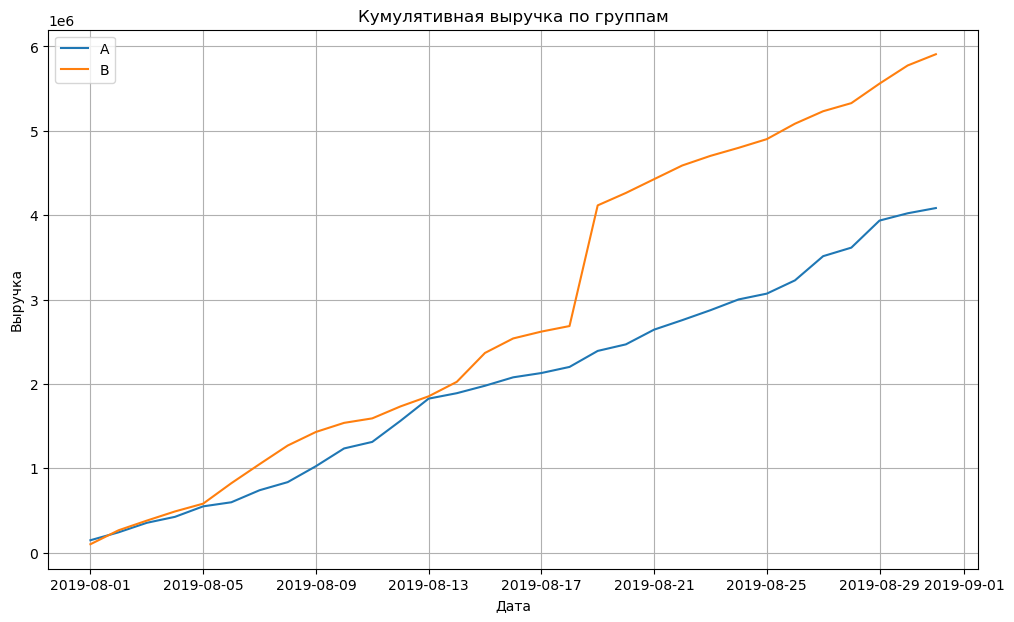

In [46]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_A = cumulative_data[cumulative_data['group'] == 'A'][['date', 'revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_B = cumulative_data[cumulative_data['group'] == 'B'][['date', 'revenue', 'orders']]

# задаём размер для графиков
plt.figure(figsize=(12, 7))

# график выручки группы А
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='A')

# график выручки группы В
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='B')

plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid()
plt.legend()
plt.show()

**Выручка в группе А увеличивается практически равномерно в течение теста. В группе В выручка тоже растет, но виден явный скачок. Это может говорить о резком росте числа заказов или резком росте дорогих заказов. Возможно это аномальные заказы.**

#### Построим график кумулятивного среднего чека по группам

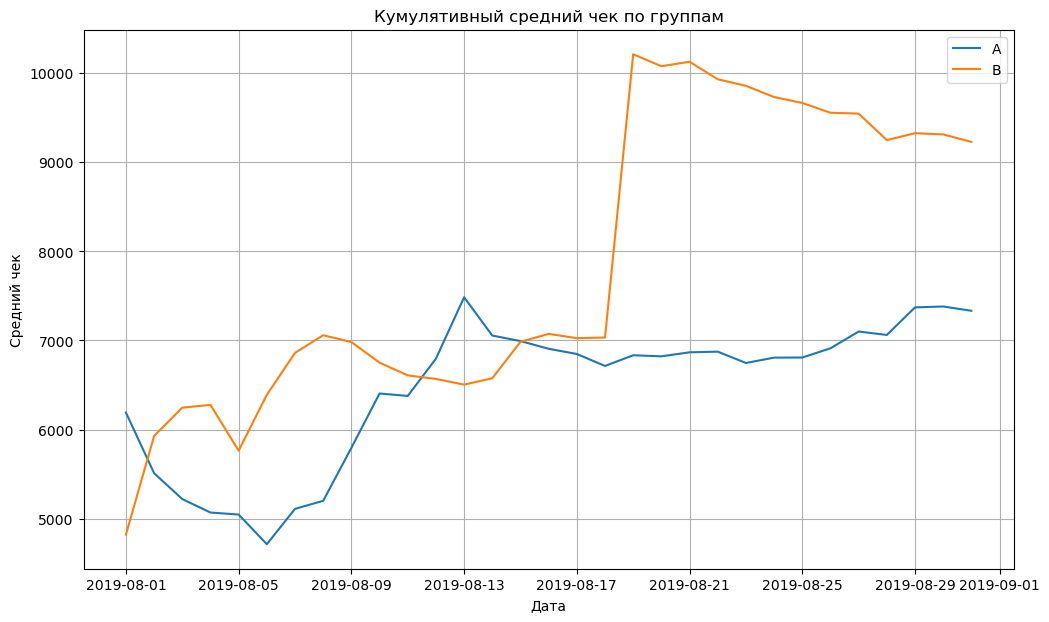

In [22]:
# задаём размер для графиков
plt.figure(figsize=(12, 7))

plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'] / cumulative_revenue_A['orders'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'] / cumulative_revenue_B['orders'], label='B')
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.grid()
plt.legend()
plt.show()

**Колебания кумулятивного значения среднего чека в группе A во второй половине теста снижаются и становится более равномерным, что не скажешь о группе В. Где постоянные колебание и виден резкий рост. Требуется анализ выбросов.**

#### Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

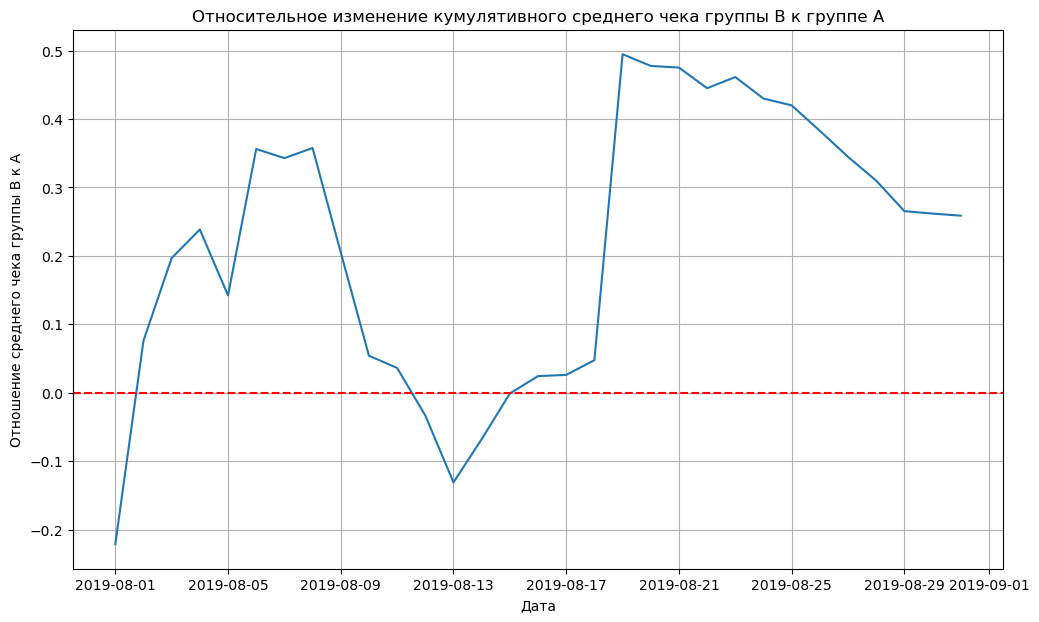

In [23]:
# соберем данные в одном датафрейме
merged_cumuiative_revenue = cumulative_revenue_A.merge(cumulative_revenue_B, left_on='date', right_on='date', suffixes=['A', 'B'])

# строим отношение средних чеков
plt.figure(figsize=(12, 7))
plt.plot(merged_cumuiative_revenue['date'], (merged_cumuiative_revenue['revenueB']/merged_cumuiative_revenue['ordersB'])/(merged_cumuiative_revenue['revenueA']/merged_cumuiative_revenue['ordersA'])-1)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Относительное изменение кумулятивного среднего чека группы В к группе А')
plt.xlabel('Дата')
plt.ylabel('Отношение среднего чека группы В к А')
plt.grid()
plt.show()

**График различия между группами резко скачет. Что говорит о том, что есть крупные заказы и выбросы.**

#### Построим график кумулятивного среднего количества заказов на посетителя по группам

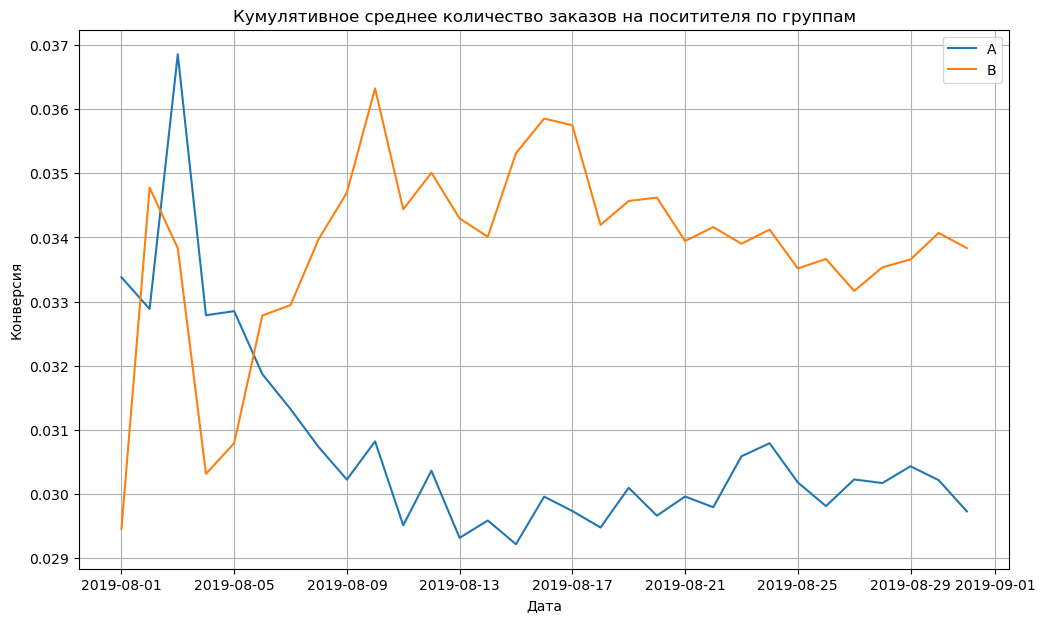

In [24]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе А
cumulative_data_A = cumulative_data[cumulative_data['group'] == 'A']

# отделяем данные по группе B
cumulative_data_B = cumulative_data[cumulative_data['group'] == 'B']

# строим графики
plt.figure(figsize=(12, 7))
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='B')
plt.title('Кумулятивное среднее количество заказов на поситителя по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.grid()
plt.legend()
plt.show()

**Графики колеблються. У группы В конверсия больше, чем у группы А. Хотя в начале теста все было наоборот.**

#### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

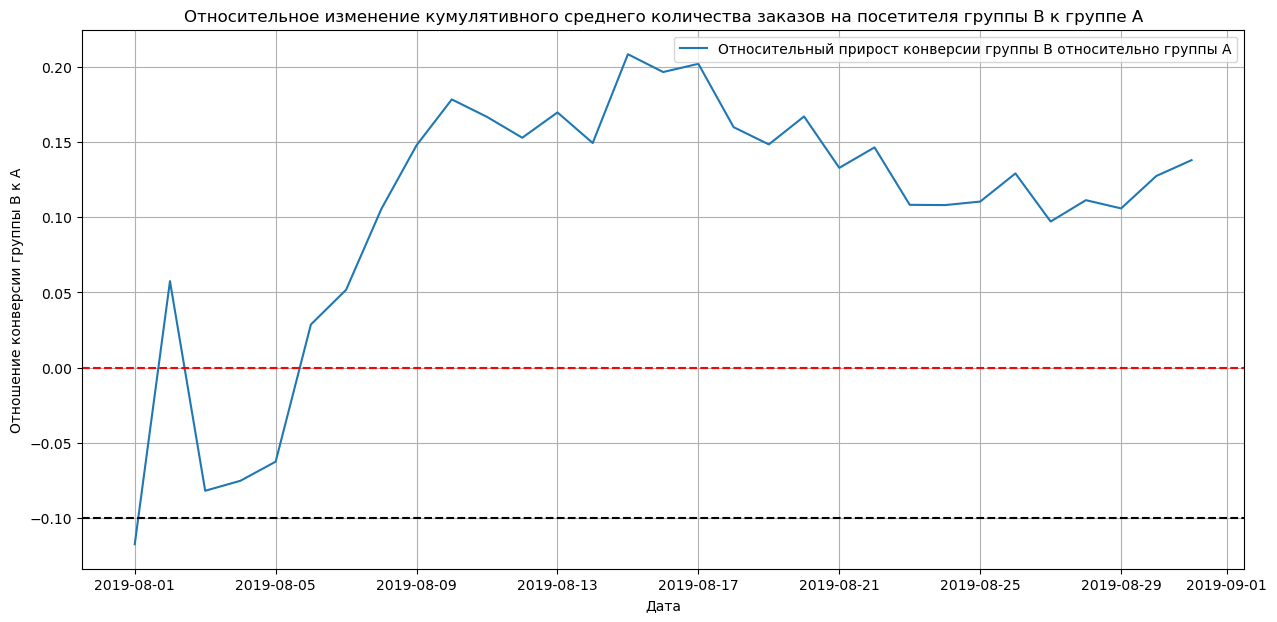

In [47]:
merged_cumulative_conversions = cumulative_data_A[['date', 'conversion']].merge(cumulative_data_B[['date', 'conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# строим график
plt.figure(figsize=(15, 7))
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1,label='Относительный прирост конверсии группы B относительно группы A')
plt.legend()

plt.axhline(y=0, color='red', linestyle='--')
plt.axhline(y=-0.1, color='black', linestyle='--')
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Отношение конверсии группы В к А')
plt.grid()
plt.show()

**Группа В в начале проигрывала группе А, но затем вырвалась вперед.**

#### Построим точечный график количества заказов по пользователям

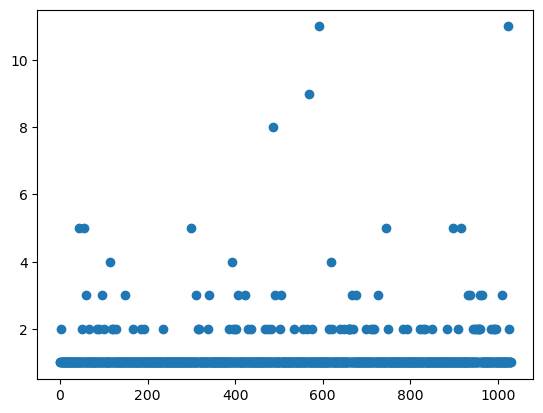

In [26]:
orders_by_users = (orders.groupby('visitorId', as_index=False).agg({'transactionId' : 'nunique'}))
orders_by_users.columns = ['userid', 'orders']
x1_values = pd.Series(range(0, len(orders_by_users)))
plt.scatter(x1_values, orders_by_users['orders'])
plt.show()

**Много пользователей с 1-2 заказами. Пользователй заказавших более двух раз мало**

#### Посчитаим 95-й и 99-й перцентили количества заказов на пользователя

In [27]:
np.percentile(orders_by_users['orders'], [90, 95, 99])

array([1., 2., 4.])

**Не более 5% совершали более двух заказов, и не более 1% делали больше 4 заказов. Аномальными пользователями будем считать пользователей совершивших более 4 заказов.**

#### Построим точечный график стоимостей заказов

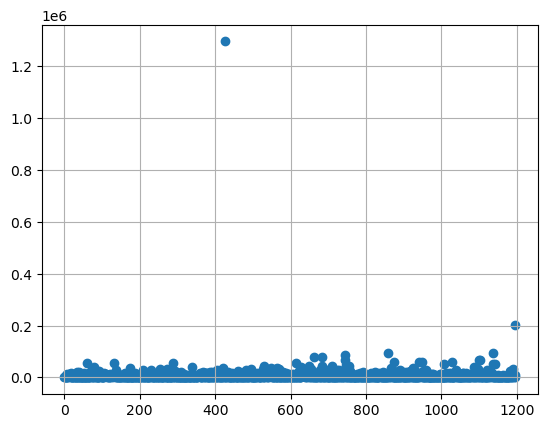

In [48]:
x2_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x2_values, orders['revenue'])
plt.grid()
plt.show()

**Видно два явных выброса. Один из которых переваливает за 1 200 000.**

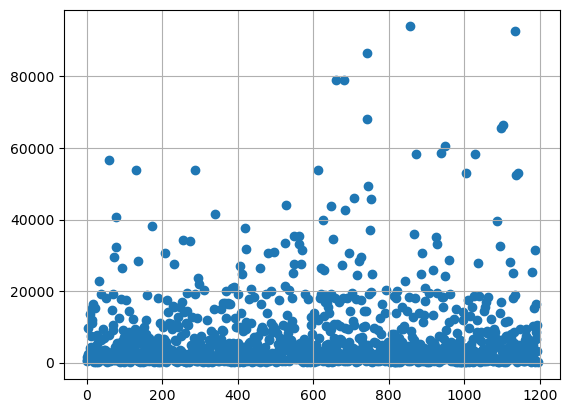

In [49]:
orders_for_plot = orders[orders['revenue']<=200000]['revenue']
x3_values = pd.Series(range(0,len(orders_for_plot)))
plt.scatter(x3_values, orders_for_plot)
plt.grid()
plt.show()

#### Посчитаим 95-й и 99-й перцентили стоимости заказов

In [30]:
np.percentile(orders['revenue'], [90, 95, 99])

array([18168. , 28000. , 58233.2])

**Не более, чем у 5% заказов чек дороже 28 000, и не более, чем у 1% заказов чек дороже 58 000. Аномальными будем считать заказы дороже 28 000**

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

**Сформируем гипотезы.**
- **Нулевая:** Различий в среднем количестве заказов между группами нет.
- **Альтернативная:** Различия в среднем количестве заказов между группами есть
- **alpha=0.05**

In [31]:
# Подготовим данные
visitorsA_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsA_daily.columns = ['date', 'visitors_per_dateA']

visitorsA_cummulative = visitorsA_daily.apply(
    lambda x: visitorsA_daily[visitorsA_daily['date'] <= x['date']].agg(
        {'date' : 'max', 'visitors_per_dateA' : 'sum'}
    ),
    axis=1,
)
visitorsA_cummulative.columns = ['date', 'visitors_cummulativeA' ]

visitorsB_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsB_daily.columns = ['date', 'visitors_per_dateB']

visitorsB_cummulative = visitorsB_daily.apply(
    lambda x: visitorsB_daily[visitorsB_daily['date'] <= x['date']].agg(
        {'date' : 'max', 'visitors_per_dateB' : 'sum'}
    ),
    axis=1,
)
visitorsB_cummulative.columns = ['date', 'visitors_cummulativeB' ]

ordersA_daily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
)
ordersA_daily.columns = ['date', 'orders_per_dateA', 'revenue_per_dateA']

ordersA_cummulative = ordersA_daily.apply(
    lambda x: ordersA_daily[ordersA_daily['date'] <= x['date']].agg(
        {'date' : 'max', 'orders_per_dateA' : 'sum', 'revenue_per_dateA' : 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersA_cummulative.columns = ['date', 'orders_cummulativeA', 'revenue_cummulativeA']

ordersB_daily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
)
ordersB_daily.columns = ['date', 'orders_per_dateB', 'revenue_per_dateB']

ordersB_cummulative = ordersB_daily.apply(
    lambda x: ordersB_daily[ordersB_daily['date'] <= x['date']].agg(
        {'date' : 'max', 'orders_per_dateB' : 'sum', 'revenue_per_dateB' : 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersB_cummulative.columns = ['date', 'orders_cummulativeB', 'revenue_cummulativeB']

data = (
    ordersA_daily.merge(
        ordersB_daily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersA_cummulative, left_on='date', right_on='date', how='left')
    .merge(ordersB_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsA_daily, left_on='date', right_on='date', how='left')
    .merge(visitorsB_daily, left_on='date', right_on='date', how='left')
    .merge(visitorsA_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsB_cummulative, left_on='date', right_on='date', how='left')
)
data.head()

,date,orders_per_dateA,revenue_per_dateA,orders_per_dateB,revenue_per_dateB,orders_cummulativeA,revenue_cummulativeA,orders_cummulativeB,revenue_cummulativeB,visitors_per_dateA,visitors_per_dateB,visitors_cummulativeA,visitors_cummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Описание:
- date — дата;
- orders_per_dateA — количество заказов в выбранную дату в группе A;
- revenue_per_dateA — суммарная выручка в выбранную дату в группе A;
- orders_per_dateB — количество заказов в выбранную дату в группе B;
- revenue_per_dateB — суммарная выручка в выбранную дату в группе B;
- orders_cummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
- revenue_cummulativeA — суммарная выручка до выбранной даты включительно в группе A;
- orders_cummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
- revenue_cummulativeB — суммарная выручка до выбранной даты включительно в группе B;
- visitors_per_dateA — количество пользователей в выбранную дату в группе A;
- visitors_per_dateB — количество пользователей в выбранную дату в группе B;
- visitors_cummulativeA  — количество пользователей до выбранной даты включительно в группе A;
- visitors_cummulativeB — количество пользователей до выбранной даты включительно в группе B. 

In [32]:
orders_by_usersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId' : pd.Series.nunique})
)
orders_by_usersA.columns = ['userid', 'orders']

orders_by_usersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId' : pd.Series.nunique})
)
orders_by_usersB.columns = ['userid', 'orders']

# объявим переменные в которых пользователям из разных груаа будет соответствовать количество заказов
sampleA = pd.concat(
    [orders_by_usersA['orders'], pd.Series(
        0, index=np.arange(data['visitors_per_dateA'].sum() - len(orders_by_usersA['orders'])
                          ), name='orders')], axis=0
)

sampleB = pd.concat(
    [orders_by_usersB['orders'], pd.Series(
        0, index=np.arange(data['visitors_per_dateB'].sum() - len(orders_by_usersB['orders'])
                          ), name='orders')], axis=0
)

In [33]:
print(f'p-value: {"{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1])}') 
print(f'Относительное различие: {"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1)}')

p-value: 0.017
Относительное различие: 0.138


**p-value по "сырым" данным меньше 0.05. Нулевую гипотезу о том, что статистически значимых различий между группами нет - отвергаем. Анализ показывает, что в среднем количестве заказов между группами есть статистически значимые различия.
Относительный прирост группы В равен 13.8%**

#### Посчитаим статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

**Сформируем гипотезы.**:
- **Нулевая:** Различий в среднем чеке между группами нет. 
- **Альтернативная:** Различия в среднем чеке между группами есть.
- **alpha=0.05**

In [34]:
print(f'p-value: {"{0:.3f}".format(stats.mannwhitneyu(orders[orders["group"]=="A"]["revenue"], orders[orders["group"]=="B"]["revenue"])[1])}')
print(f'Относительное различие: {"{0:.3f}".format(orders[orders["group"]=="B"]["revenue"].mean()/orders[orders["group"]=="A"]["revenue"].mean() - 1)}')

p-value: 0.729
Относительное различие: 0.259


**p-value значительно больше 0.05. Значит нулевую гипотезу не отвергаем. Статистически значимых различий в среднем чеку между группами нет. Относительное различие между группами 25.9% - наблюдаемые различия не являются значимыми при таком уровне значимости, а следовательно были получены случайно**

#### Посчитаим статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

**Примем за аномальных пользователей тех, кто совершил от более 2 заказов или совершил заказ дороже 30 000. Таким образом мы уберем 5% пользователей с наибольшим числом заказов и 5% пользователей с дорогими заказами.**

In [35]:
users_with_manyorders = pd.concat(
    [
        orders_by_usersA[orders_by_usersA['orders'] > 2]['userid'],
        orders_by_usersB[orders_by_usersB['orders'] > 2]['userid']
    ],
    axis=0,
)
users_with_expensivorders = orders[orders['revenue'] > 28000]['visitorId']
abnormal_users = (
    pd.concat([users_with_manyorders, users_with_expensivorders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormal_users.shape[0]

74

In [36]:
sampleA_filtered = pd.concat(
    [
        orders_by_usersA[
            np.logical_not(orders_by_usersA['userid'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_dateA'].sum() - len(orders_by_usersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB_filtered = pd.concat(
    [
        orders_by_usersB[
            np.logical_not(orders_by_usersB['userid'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_dateB'].sum() - len(orders_by_usersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [37]:
# применим статистический критерий Манна-Уитни к полученным выборкам
display(
    '{0:.3f}'.format(stats.mannwhitneyu(sampleA_filtered, sampleB_filtered)[1]),
    '{0:.3f}'.format(sampleB_filtered.mean()/sampleA_filtered.mean()-1)
)

'0.013'

'0.173'

**Как в случае и с сырыми данными есть статистистически значимые различия между группами**

#### Посчитаим статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [38]:
display(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    ),

    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

'0.738'

'-0.020'

**p-value практически не изменилось. Но разница между сегментами уменьшилась. Средний чек группы В ниже среднего чека группы А. Разница 2%**  

#### Примем решение по результатам теста:

**Принимаем решение остановить тест. Так как группа В статистически значимо лучше группы А по метреке конверсии. Статистической значимости по среднему чеку обнаружить не удалось. Так как конечная цель является увелечение прибыли, то отделу маркетинга необходимо ориентироваться на данный тест в рамках лучшей конверсии в группе В и исходя из этого создавать соответствующе маркетинговые продукты.**

### Общий вывод:
1. Изучили предоставленные данне. Ознакомились с наименованиями столбцов, типами данных, и др. Проверили на пропуски и дубликаты;
2. Провели приоритизацию гипотез методами ICE и RICE;
3. Построили график кумулятивной выручки по группам - Выяснили, что выручка в группе А увеличивается равномерно, а в группе В выручка тоже растет, но виден явный скачок.
4. Построили график кумулятивного среднего чека по группам - Выяснили, что колебания кумулятивного значения среднего чека в группе A во второй половине теста снижаются и становится более равномерным, а у группы В постоянные колебания м виден резкий скаячок;
5. Построили график относительного изменения кумулятивного среднего чека группы B к группе A - Обнаружили значительные колебания в графике.
6. Построили точечный график количества заказов по пользователям - Выяснили, что много пользователей с 1-2 заказами;
7. Посчитали 95-й и 99-й перцентили количества заказов на пользователя - Определили аномальных пользователей, это пользователи совершившие более 2 заказов;
8. Построили точечный график стоимостей заказов - Обнаружили несколько выбросов;
9. Посчитали 95-й и 99-й перцентили стоимости заказов - Приняли решение аномальными считать заказы дороже 28 000;
10. Посчитали статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным - Выяснили, что p-value по "сырым" данным меньше 0.05. Значит между группами есть статистически значимые различия;
11. Посчитали статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным - Выяснили, что p-value значительно больше 0.05. Значит статистически значимых различий в среднем чеку между группами нет. Относительное различие между группами 25.9%;
12. Посчитали статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным - Выяснили что, как и в случае с сырыми данными есть статистистически значимые различия между группами;
13. Посчитали статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным - Выяснили, что p-value практически не изменилось по сравнению с не очищенными данными. Но разница между сегментами уменьшилась. Средний чек группы В ниже среднего чека группы А;
14. По результатам теста приняли решение остановить тест. Так как группа В статистически значимо лучше группы А по метреке конверсии. Статистической значимости по среднему чеку обнаружить не удалось. Так как конечная цель является увелечение прибыли, то отделу маркетинга необходимо ориентироваться на данный тест в рамках лучшей конверсии в группе В и исходя из этого создавать соответствующе маркетинговые продукты.